# 앙상블

### 보팅

In [2]:
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

breast_cancer = load_breast_cancer()
data_df = pd.DataFrame(breast_cancer.data, columns = breast_cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [8]:
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier()

vo_clf = VotingClassifier(estimators=[('LR',lr_clf),('KNN',knn_clf)], voting="soft")

X_train, X_test, y_train, y_test = train_test_split(breast_cancer.data,breast_cancer.target,
                                                   test_size=0.2,random_state=156)
vo_clf.fit(X_train, y_train)
pred= vo_clf.predict(X_test)
print("VotingClassifier의 정확도 : {0:.4f}".format(accuracy_score(pred, y_test)))

classifiers=[lr_clf,knn_clf]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    print("{0}의 정확도 : {1:.4f}".format(classifier.__class__.__name__, accuracy_score(pred, y_test)))

VotingClassifier의 정확도 : 0.9474
LogisticRegression의 정확도 : 0.9386
KNeighborsClassifier의 정확도 : 0.9035


C:\Users\soyunjung\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\soyunjung\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

약한 학습기 여러 개를 합쳐 앙상블 학습을 하면 개별 학습보다 더 정확한 예측을 할 수 있다.

### 배깅 - 랜덤포레스트

사용자 활동인지 데이터 가져오고 학습/테스트 데이터 분리

In [9]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(old_feature_name_df.groupby("column_name").cumcount(),
                                  columns=["dup_cnt"])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(),feature_dup_df, how="outer")
    new_feature_name_df["column_name"] = new_feature_name_df[["column_name","dup_cnt"]].apply(lambda x: x[0]+'_'+str(x[1])
                                                                                              if x[1]>0 else x[0], axis=1)
    new_feature_name_df= new_feature_name_df.drop(["index"],axis=1)
    return new_feature_name_df

In [10]:
def get_human_dataset():
    feature_name_df = pd.read_csv("./datasets/human_activity/features.txt", sep="\s+",\
                             header=None, names=["column_index", "column_name"])
    
    feature_name_df = get_new_feature_name_df(feature_name_df)
    
    feature_name= feature_name_df.iloc[:,1].values.tolist()
    
    X_train = pd.read_csv("./datasets/human_activity/train/X_train.txt",sep="\s+",
                     names = feature_name)
    X_test = pd.read_csv("./datasets/human_activity/test/X_test.txt",sep="\s+",
                     names = feature_name)
    y_train = pd.read_csv("./datasets/human_activity/train/y_train.txt",sep="\s+",
                     header=None,names = ["action"])
    y_test = pd.read_csv("./datasets/human_activity/test/y_test.txt",sep="\s+",
                     header=None,names = ["action"])
    return X_train,X_test,y_train,y_test

X_train,X_test,y_train, y_test = get_human_dataset()

랜덤포레스트로 학습/예측/평가

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
print("RandomForestClassifier의 정확도 : {0:.4f}".format(accuracy_score(pred, y_test)))

<ipython-input-13-f9c28deb722d>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(X_train, y_train)


RandomForestClassifier의 정확도 : 0.9287


GridSearchCV로 교차검증 및 하이퍼 파라미터 튜닝

In [20]:
from sklearn.model_selection import GridSearchCV

params={
    "n_estimators":[100],
    "max_depth":[6,8,10,12],
    "min_samples_leaf":[8,12,18],
    "min_samples_split":[8,16,20]
}
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv=2, n_jobs=-1)
grid_cv.fit(X_train,y_train)

print("최적 하이퍼 파라미터 :", grid_cv.best_params_)
print("최고 예측 정확도 : {0:.4f}".format(grid_cv.best_score_))

C:\Users\soyunjung\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


최적 하이퍼 파라미터 : {'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 20, 'n_estimators': 100}
최고 예측 정확도 : 0.9153


튜닝된 하이퍼 파라미터로 재학습 및 예측 평가

In [22]:
rf_clf1 = RandomForestClassifier(n_estimators=300, max_depth=12, min_samples_leaf = 8, min_samples_split=20)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print("예측 정확도 : {0:.4f}".format(accuracy_score(pred, y_test)))

<ipython-input-22-725095e06d13>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf1.fit(X_train, y_train)


예측 정확도 : 0.9250


개별 feature들의 중요도 시각화

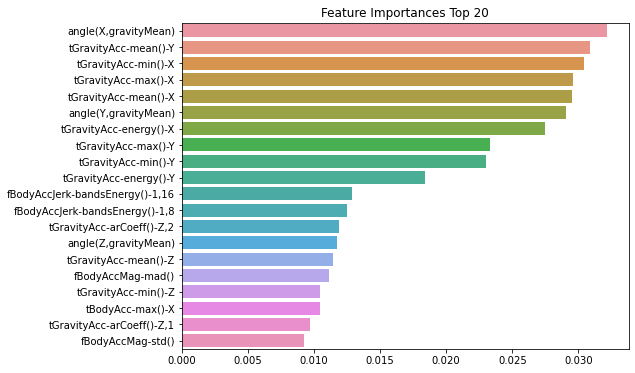

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title("Feature Importances Top 20")
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()